# Optomechanical Noise Model of the Windchime Sensor but in Space

In [124]:
# Optomechanical Noise Model of the Windchime Sensor but in Space
# Basically, no thermal noise from the spring 
#! pip install ipympl
%matplotlib ipympl

In [188]:
import json
import unittest
import time

import numpy as np
import scipy
from scipy import stats
from math import pi, sqrt, ceil
from scipy.optimize import curve_fit
from scipy import constants
from numba import njit, jit
from tqdm import tqdm, trange

%matplotlib inline
import matplotlib # plotting libraries
from matplotlib import animation, rc, cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D

%matplotlib ipympl
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

#import plotting as pl

from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.special import kn

#jupyter labextension install @jupyter-widgets/jupyterlab-manager
#jupyter labextension install @jupyter-matplotlib

In [126]:
Q = 1e6
wo = 2*np.pi*1.94*1e14 #Hz
Qo = 1e8
v = 220e3 #m/s
wm = 1e-8 #Hz
planck_mass = 2.176434e-8 #kg
l = 0.015 # cavity length. #EVAN ASSUMPTION.
sensor_mass = 0.2 #kg
#sensor_density = 3.17*10**3 #silicon nitride
sensor_density = 19.3*10**3 #tungsten
w_m = 1e-8
Pin = 1
b = (sensor_mass/(4/3*pi*sensor_density))**(1/3)

T = 0.01 #K

pressure = 1e-15 #Pa

QNR = 10**(25) # 250 dB

In [127]:
(sensor_mass/(4/3*pi*sensor_density))**(1/3)

0.013524711997751414

# <center> Check the Noise Functions</center>

In [128]:
#solving for individual sections of the noise model. 
                     
def shot_noise(w,Pin,wo,Qo,l=l,w_m=wm,Q=Q,m=sensor_mass, use_G_opt=False, w_opt=1):
    
    h_bar = constants.hbar # checked.
    gamma = float(w_m) / float(Q) # damping. # checked. 
    m = float(m) #checked.
    k = wo/Qo #checked. 
    
    G = np.sqrt(2)*wo*np.sqrt(Pin/(h_bar*wo*k))/l # checked. 
    if use_G_opt:
        xc_opt = abs(k/(w_opt**2+(k**2)/4)) #checked
        xm_opt = abs((1/m**2)/((w_opt**2-w_m**2)**2+(gamma**2)*w_opt**2))#checked. 
        G = np.sqrt(1/(h_bar*(xc_opt)*(xm_opt)**0.5))
    abs_G = abs(G)
    
    abs_xc = abs(k/(w**2+(k**2)/4)) #checked
    abs_xm = abs((1/m**2)/((w**2-w_m**2)**2+(gamma**2)*w**2))#checked. 
    
    SN = 1/((abs_G**2)*(abs_xc)*(abs_xm))# checked.

    return SN
               
def back_action(w, Pin, wo, Qo,l=l,w_m=wm,Q=Q,m=sensor_mass, use_G_opt=False, w_opt=1):
    
    h_bar = constants.hbar
    gamma = float(w_m) / float(Q)
    k = wo/Qo
    G = np.sqrt(2)*wo*np.sqrt((Pin)/(h_bar*wo*k))/l # checked. 
    if use_G_opt:
        xc_opt = abs(k/(w_opt**2+(k**2)/4)) #checked
        xm_opt = abs((1/m**2)/((w_opt**2-w_m**2)**2+(gamma**2)*w_opt**2))#checked. 
        G = np.sqrt(1/(h_bar*(xc_opt)*(xm_opt)**0.5))
    abs_G = abs(G)
    
    xc = k/(w**2+(k**2)/4) # checked.
    abs_xc = abs(xc)

    BA = (h_bar**2)*(abs_G**2)*(abs_xc) #checked. 
   
    #print('BA is a ', type(BA))
    return BA
        
# mechanical thermal noise    
def thermal_noise(m, T, w_m, Q):

    k_b = float(constants.k) # Boltzmann constant
    m = float(m) # mass of sensor
    T = float(np.array(T)) # temperature Kelvin
    gamma = float(w_m) / float(Q) # damping.

    TN = 4*k_b*m*T*gamma #checked. 
    #print('TN is a', type(TN))
    return TN

def thermal_noise_gas(T, m=sensor_mass, sensor_density=sensor_density, pressure=pressure):

    k_b = float(constants.k) # Boltzmann constant
    gas_mass = 6.646e-27 # mass of Helium in kg.
    T = float(np.array(T)) # temperature Kelvin
    
    sensor_radius = (sensor_mass/(4/3*np.pi*sensor_density))**(1/3)
    sensor_area = (sensor_radius**2)*np.pi
    
    TN = pressure*sensor_area*np.sqrt(gas_mass*k_b*T)
    
    return TN

%matplotlib inline

fig = plt.figure(figsize=(8, 6), dpi=110)
ax = fig.add_subplot(111)

X = np.logspace(-25,11,10000)
SN = shot_noise(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)
BA = back_action(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)
TN = thermal_noise(m=sensor_mass, T=0.01, w_m=1, Q=1e4)
TN_gas = thermal_noise_gas(T=0.01)

ax.plot(X, SN, label='Shot noise')
ax.plot(X, BA, label='Backaction')
ax.plot(X, [TN]*len(X), label='Mechanical thermal noise')
ax.plot(X, [TN_gas]*len(X), label='Gas thermal noise')

ax.plot(X, SN+BA+TN+TN_gas, label='Total noise')

ax.legend()
ax.set(xscale='log', yscale='log', ylabel='Noise PSD (m^2/s^4)/Hz', xlabel='angular frequency (Hz)')

plt.show()

In [129]:
def signal_model(w, dm_mass=planck_mass, b=5e-3, v=v, sensor_mass=sensor_mass):
    return 2*(constants.G*dm_mass*w)**2/(np.pi*v**4)*(kn(1, w*b/v)**2)*sensor_mass**2

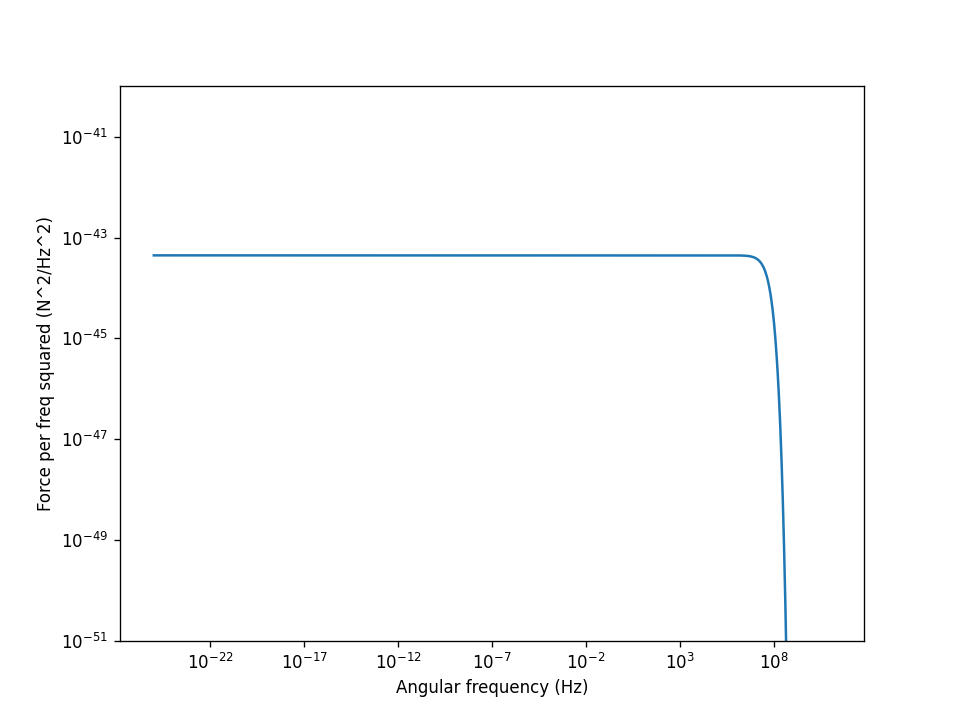

In [130]:
X = np.logspace(-25,11,10000)

fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(111)
ax.plot(X, signal_model(X))
ax.set(xscale='log', yscale='log', ylabel='Force per freq squared (N^2/Hz^2)', xlabel='Angular frequency (Hz)', ylim=[1e-51, 1e-40])
plt.show()

# <center>Now It's Time For Interactions!!</center>

In [131]:
def integrand_signal_model_exponential(integral_var, w_m, wo, Qo, dm_mass=planck_mass, b=(sensor_mass/(4/3*pi*sensor_density))**(1/3), v=v, Pin=Pin,T=T, QNR=QNR, Q=Q, sensor_mass=sensor_mass):
    w = np.exp(integral_var)
    N = (
        shot_noise(w, Pin, wo, Qo, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 + 
        back_action(w, Pin, wo, Qo, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 +
        #thermal_noise(T=T, w_m=w_m, Q=Q, m=sensor_mass) +
        thermal_noise_gas(T=T)
    )
    S_sq = signal_model(w, dm_mass=dm_mass, b=b, v=v, sensor_mass=sensor_mass)
    return S_sq/N*w
    #return N

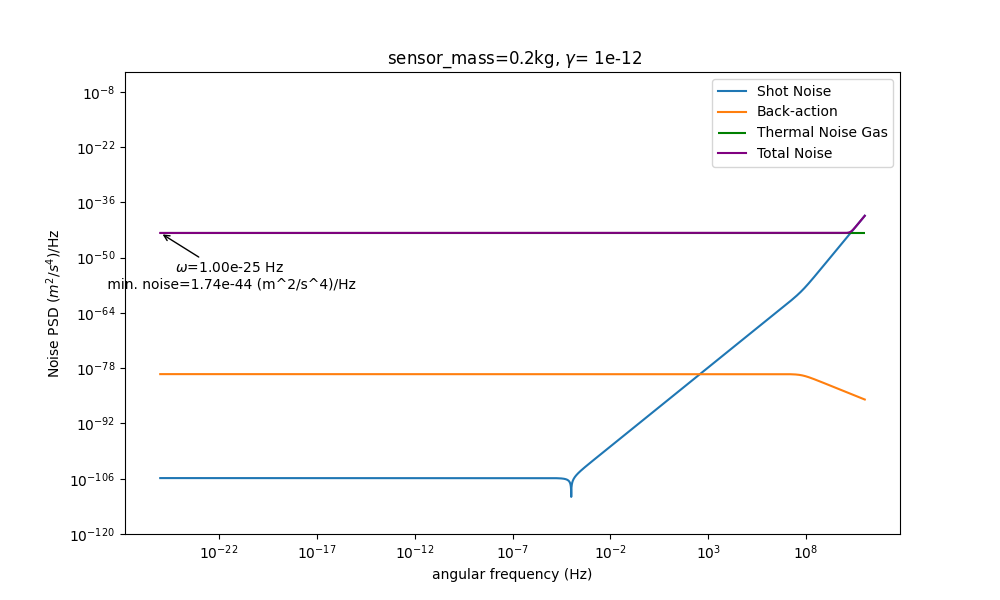

In [132]:
%matplotlib inline
%matplotlib ipympl

X = np.logspace(-25,11,10000)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
ax1 = fig1.add_subplot(1, 1, 1)

def update(Q=widgets.FloatLogSlider(value=1e8,base=10,min=0,max=8,step=1e-10,description='Q', layout=widgets.Layout(width='80%')), 
           w_m=widgets.FloatLogSlider(value=1e-4,base=10,min=-4,max=10,step=1e-10, description='w_m (Hz)', layout=widgets.Layout(width='80%')),
           wo=widgets.FloatLogSlider(value=2*np.pi*1.94*10e14,base=10,min=11,max=19,step=1e-10,description='w_0 (Hz)', layout=widgets.Layout(width='80%')),
           Qo=widgets.FloatLogSlider(value=10*10e6,base=10,min=2,max=10,step=1e-10,description='Q_0', layout=widgets.Layout(width='80%')),
           T=widgets.FloatSlider(value=0.01,min=0.01,max=400,step=0.01,description='T (K)', layout=widgets.Layout(width='80%')),
           Pin=widgets.FloatLogSlider(value=1,base=10,min=-5,max=14,step=1e-10,description='P_input (W)', layout=widgets.Layout(width='80%'))
           ):
    
    ax1.clear()
    ax1.set(xscale='log',yscale='log', ylabel='Noise PSD ($m^2$/$s^4$)/Hz', xlabel='angular frequency (Hz)', title=' sensor_mass='+str(sensor_mass)+'kg, $\gamma$= '+str(float('{:.6e}'.format(w_m/Q))))
    ax1.set_ylim([1e-120, 1e-3])
    
    SN = shot_noise(X, Pin, wo, Qo, w_m=w_m, Q=Q, use_G_opt=False, w_opt=1e6)/QNR**2
    BA = back_action(X, Pin, wo, Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)/QNR**2 
    #TN = thermal_noise(m=sensor_mass, T=T, w_m=w_m, Q=Q)
    TNG = thermal_noise_gas(T=T)
    
    total_noise = SN+BA+TNG
    
    ax1.plot(X, SN, label='Shot Noise')
    ax1.plot(X, BA, label='Back-action')
    #ax1.hlines(TN, xmin=X[0],xmax=X[-1], color='red', label='Thermal Noise')
    ax1.hlines(TNG,xmin=X[0],xmax=X[-1], color='green', label='Thermal Noise Gas')
    ax1.plot(X, total_noise, color='purple', label='Total Noise')
    
    ax1.legend()
    label = '$\omega$=' + '{:.2e}'.format(X[np.argmin(total_noise)]) + ' Hz \n min. noise='+'{:.2e}'.format(min(total_noise))+' (m^2/s^4)/Hz'
    ax1.annotate(label, (X[np.argmin(total_noise)], min(total_noise)), textcoords="offset points", xytext=(50,-40), ha='center',arrowprops=dict(arrowstyle="->"))
    # print("SN vs. w = ", shot_noise(X, 1, w_m=w_m, Q=Q, use_G_opt=True, w_opt=1e6))
    #fig.canvas.draw_idle()
    
    #print('min. freq.=', X[np.argmin(total_noise)], 'Hz, min. noise=', min(total_noise), '(m^2/s^4)/Hz') 
    
interact(update);

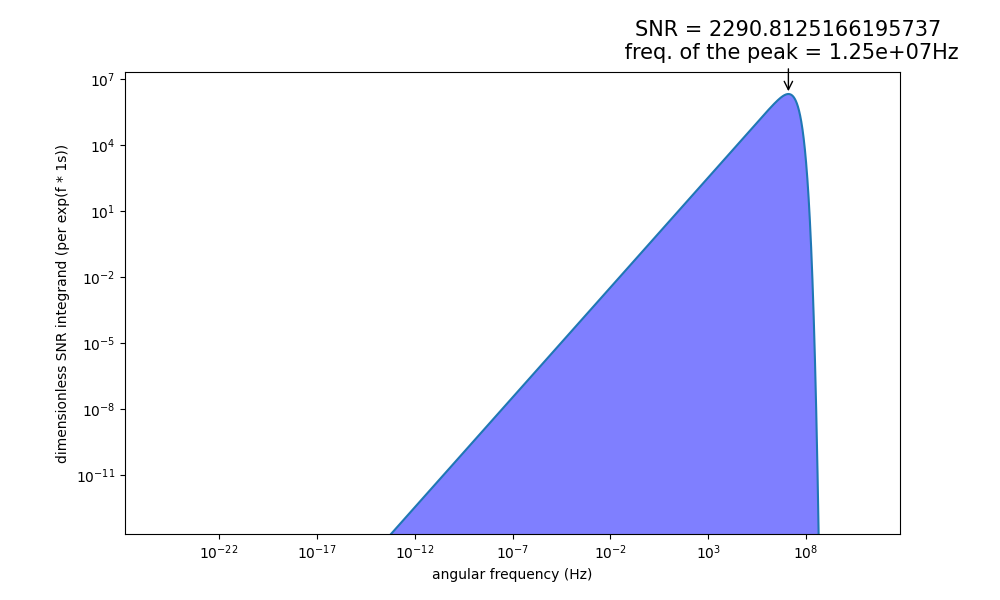

In [133]:
fig2 = plt.figure(figsize=(10, 6), dpi=100)
ax2 = fig2.add_subplot(1, 1, 1)   

log_x = np.linspace(-25/np.log10(np.e), 11/np.log10(np.e), 10000)
x = np.exp(log_x)

def update(Q=widgets.FloatLogSlider(value=1e8,base=10,min=0,max=8,step=1e-10,description='Q', layout=widgets.Layout(width='80%')), 
           w_m=widgets.FloatLogSlider(value=1,base=10,min=-4,max=10,step=1e-10, description='w_m (Hz)', layout=widgets.Layout(width='80%')),
           wo=widgets.FloatLogSlider(value=2*np.pi*1.94*10e14,base=10,min=11,max=19,step=1e-10,description='w_0 (Hz)', layout=widgets.Layout(width='80%')),
           Qo=widgets.FloatLogSlider(value=10*10e6,base=10,min=2,max=10,step=1e-10,description='Q_0', layout=widgets.Layout(width='80%')),
           T=widgets.FloatSlider(value=0.01,min=0.01,max=400,step=0.01,description='T (K)', layout=widgets.Layout(width='80%')),
           Pin=widgets.FloatLogSlider(value=1,base=10,min=-5,max=14,step=1e-10,description='P_input (W)', layout=widgets.Layout(width='80%'))
           ):
    
    ax2.clear()
    signal = integrand_signal_model_exponential(log_x, w_m, wo, Qo, dm_mass=planck_mass, b=(sensor_mass/(4/3*pi*sensor_density))**(1/3), v=v, Pin=Pin,T=T, QNR=QNR, Q=Q, sensor_mass=sensor_mass)
    ax2.plot(x, signal)
    ax2.set(xscale='log', yscale='log', xlabel='angular frequency (Hz)', ylabel='dimensionless SNR integrand (per exp(f * 1s))', ylim=[np.max(signal)*1e-20, np.max(signal)*10])

    SNR_squared = quad(integrand_signal_model_exponential, -30, 40, args=(w_m, wo, Qo, planck_mass, (sensor_mass/(4/3*pi*sensor_density))**(1/3), v, Pin, T, QNR, Q, sensor_mass))
    SNR = np.sqrt(SNR_squared)
    
    label = 'SNR = ' + str(SNR[0]) + '\n freq. of the peak = ' + '{:.2e}'.format(X[np.argmax(signal)]) + 'Hz'
    ax2.annotate(label, (X[np.argmax(signal)], max(signal)), textcoords="offset points", xytext=(0,25), ha='center', fontsize=15, arrowprops=dict(arrowstyle="->")) 

    ax2.fill(X, signal, facecolor='blue', alpha=0.5)
    
    #print('SNR, err =', SNR)
    
interact(update);

In [134]:
initial_guess=(w_m, wo, Qo, planck_mass, b, v, Pin, T, QNR, Q, sensor_mass)

In [135]:
quad(integrand_signal_model_exponential, -30, 40, args=initial_guess)

(5247821.986300904, 0.002590538390798258)

In [136]:
bad=(1.00000000e+00,  1.21893795e+15,  1.00000000e+08,  2.20634500e+04,
 -2.61507500e-02,  2.20000000e+05,  1.00000000e+00,  1.05668524e-03,
  1.00000000e+30,  1.00000000e+06,  2.01788668e-01)

In [137]:
#quad(integrand_signal_model_exponential, -30, 40, args=bad)

# <center> Plot the SNR vs QNR values </center>

In [252]:
def integrand_signal_model_exponential_2(integral_var, arg):
    w = np.exp(integral_var)
    dm_mass = planck_mass
    Pin, wo, Qo = arg 
    N = (
        shot_noise(w, Pin, wo, Qo, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 + 
        back_action(w, Pin, wo, Qo, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 +
        #thermal_noise(T=T, w_m=w_m, Q=Q, m=sensor_mass) +
        thermal_noise_gas(T=T)
    )
    S_sq = signal_model(w, dm_mass=dm_mass, b=b, v=v, sensor_mass=sensor_mass)
    return S_sq/N*w

In [253]:
def my_func(args):
    
    result=-quad(integrand_signal_model_exponential_2, -30, 40, args=args)[0]
    return result

In [254]:
QNR_list = np.logspace(0, 15, 31)
initial_guess=(Pin, wo, Qo)
bounds=((1e-12, 1), (1e11, 1e19), (1e2, 1e10))
optimal_SNR_sq = np.zeros(len(QNR_list))
optimal_Pin = np.zeros(len(QNR_list))
optimal_wo = np.zeros(len(QNR_list))
optimal_Qo = np.zeros(len(QNR_list))

for i in trange(len(QNR_list)):
    QNR = QNR_list[i]
    max_integral = scipy.optimize.minimize(my_func, initial_guess, method='Nelder-Mead')
    optimal_SNR_sq[i] = max_integral.fun   
    optimal_wo[i] = max_integral.x[0]
    optimal_Qo[i] = max_integral.x[1]
    
#print(Pin, optimal_wo, optimal_Qo)    

  0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-128-f2cd1f0db8ec>:8: RuntimeWarning: divide by zero encountered in double_scalars
  k = wo/Qo #checked.
<ipython-input-128-f2cd1f0db8ec>:17: RuntimeWarning: invalid value encountered in double_scalars
  abs_xc = abs(k/(w**2+(k**2)/4)) #checked
<ipython-input-128-f2cd1f0db8ec>:28: RuntimeWarning: divide by zero encountered in double_scalars
  k = wo/Qo
<ipython-input-128-f2cd1f0db8ec>:36: RuntimeWarning: invalid value encountered in double_scalars
  xc = k/(w**2+(k**2)/4) # checked.
<ipython-input-253-1c27a2622f2b>:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result=-quad(integrand_signal_model_exponential_2, -30, 40, args=args)[0]
<ipython-input-128-f2cd1f0db8ec>:10: RuntimeWarning: invalid value encountered in sqrt
  G = np.sqrt(2)*wo*np.sqrt(Pin/(h_bar*wo*k))/l # checked.
<ipython-input-128-f2cd1f0db8ec>:29:

[9.02767401e-01 9.03737374e-01 9.03344291e-01 9.02090135e-01
 9.00830252e-01 9.02215764e-01 8.97037471e-01 8.87318233e-01
 8.80177048e-01 8.84329749e-01 8.88680340e-01 8.80404121e-01
 8.76251167e-01 9.08641960e-01 8.59874584e-01 8.39878955e+00
 7.54914189e+00 4.77187637e-01 1.32284932e+03 1.79789934e+07
 1.20282743e+00 5.19204276e+01 3.99031611e+10 6.08254488e+10
 2.76393448e+11 7.18680904e+01 3.58231122e+11 7.14378094e+02
 5.42515929e+02 2.35436154e+10 4.75285880e+02] [ 2.21839385e+15  2.21752547e+15  2.21787720e+15  2.21899943e+15
  2.22012569e+15  2.21888045e+15  2.22350001e+15  2.23214953e+15
  2.23837910e+15  2.23414457e+15  2.22862745e+15  2.23095608e+15
  2.21970663e+15  2.14649538e+15  1.96120215e+15  1.26088009e+16
  3.79892226e+15  5.28517399e+15 -8.12916397e+17 -8.72282917e+22
 -4.85701383e+18 -4.07322521e+19 -1.68143938e+25 -2.10141787e+26
 -7.51543202e+26 -9.12659820e+21 -4.19863881e+26  8.43719453e+21
  1.54577159e+22  3.09303667e+25  6.56268429e+22]


sensor_mass = 0.2 kg
sensor_density = 19300.0 kg/m^3 (Tungsten) 
mechanical freq. w_m = 1e-08 Hz
mechanical quality factor Q = 1000000.0 
input laser power P_in = 1 W
cavity length l = 0.015 m
dark matter mass = 2.176e-08 kg
impact parameter b = 0.0135 m
temperature= 0.01 K
pressure= 1e-15 Pa


<ipython-input-255-576ea526c4a8>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(j) for j in yvalues])


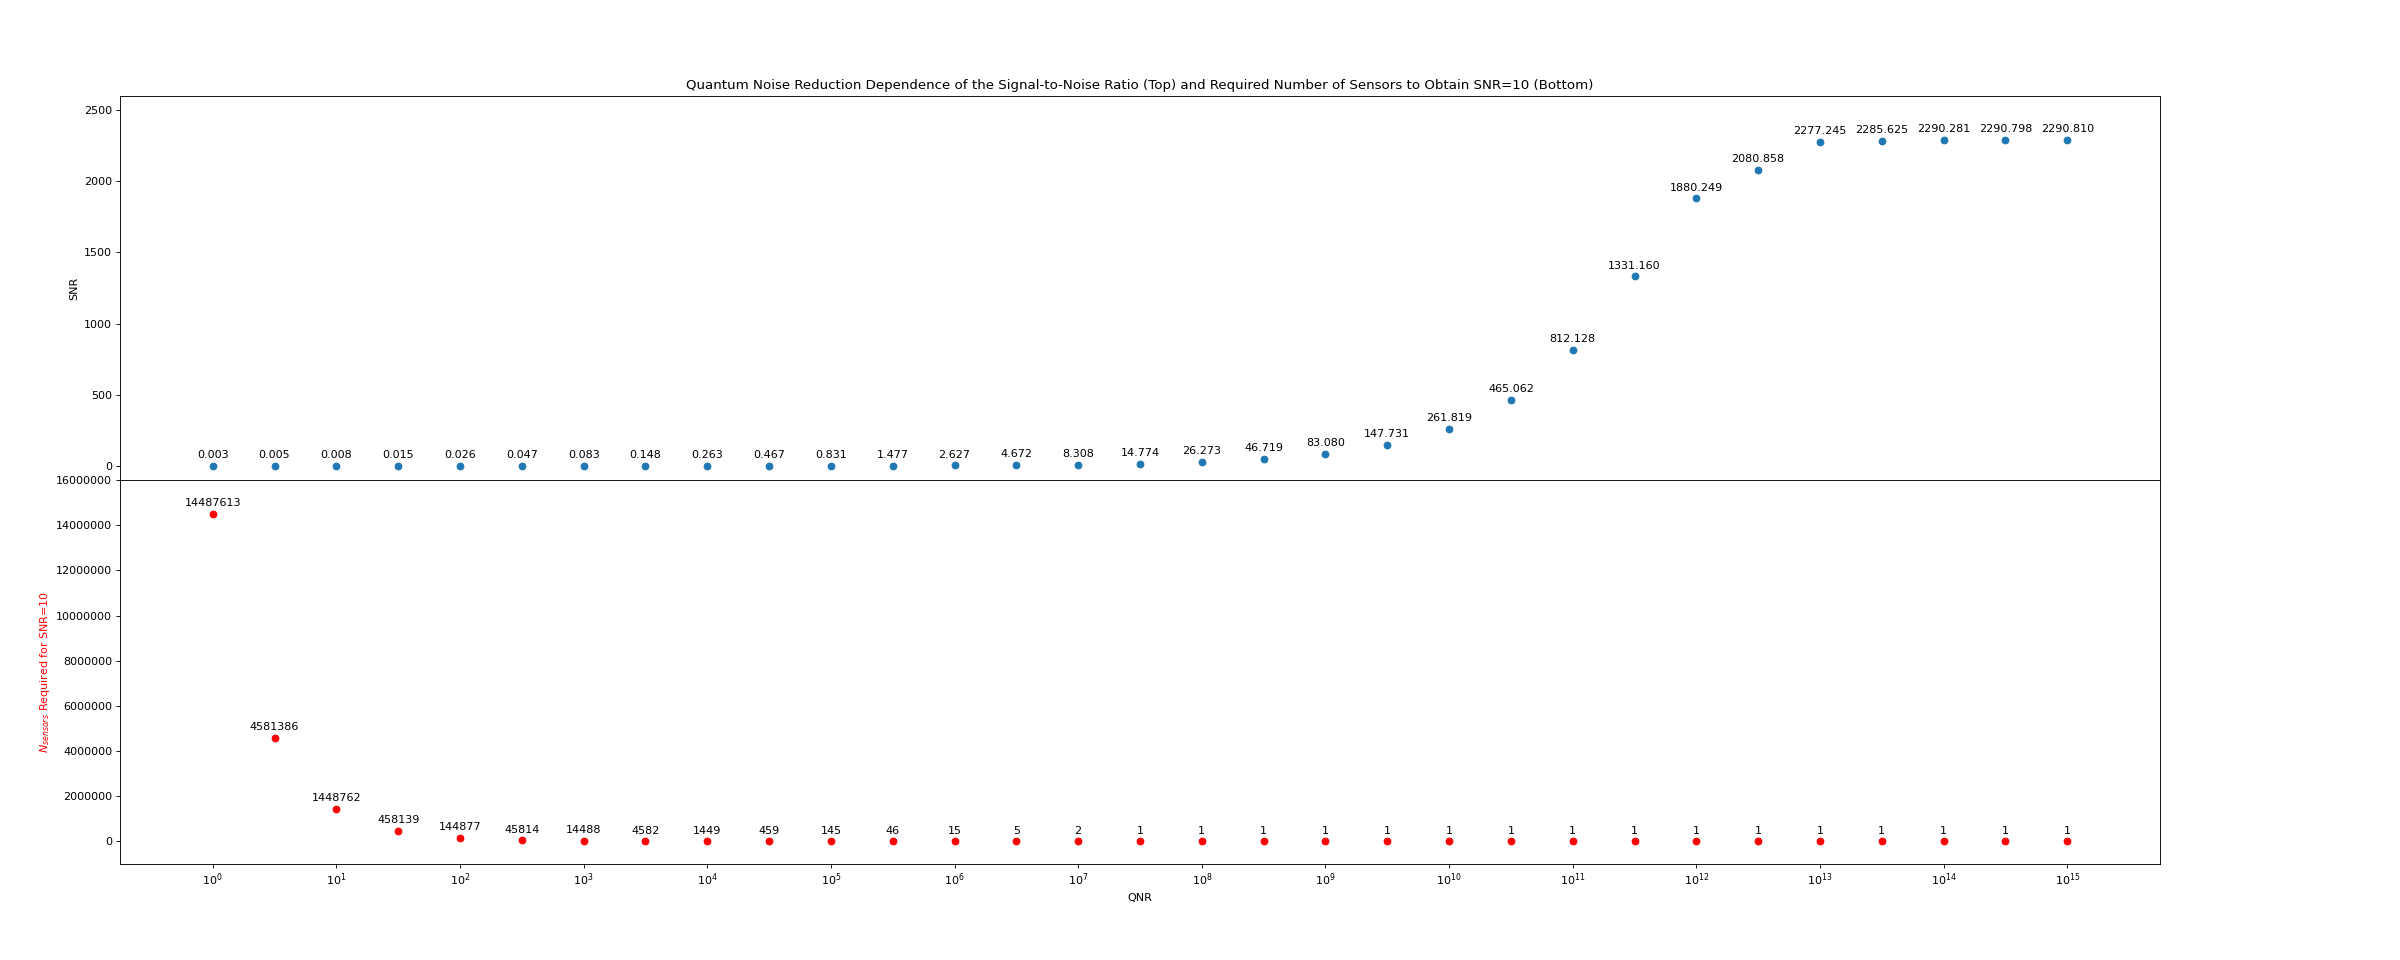

In [255]:
optimal_SNR = np.sqrt(abs(optimal_SNR_sq))
fig3  = plt.figure(figsize=(30, 12), dpi=80);
ax3 = fig3.add_subplot(211);  

print('sensor_mass =', sensor_mass, 'kg\nsensor_density =', sensor_density, 'kg/m^3 (Tungsten) \nmechanical freq. w_m =', w_m, 'Hz\nmechanical quality factor Q =', Q, '\ninput laser power P_in =', Pin, 'W\ncavity length l =', l, 'm\ndark matter mass =', "{:.3e}".format(planck_mass), 'kg\nimpact parameter b =', "{:.4f}".format(b), 'm\ntemperature=', T, 'K\npressure=', pressure, 'Pa');

ax3.clear();
ax3.scatter(QNR_list, optimal_SNR); 
ax3.set(xscale='log', xlabel='QNR', ylabel='SNR', ylim=[-1e2, 2.6e3], title='Quantum Noise Reduction Dependence of the Signal-to-Noise Ratio (Top) and Required Number of Sensors to Obtain SNR=10 (Bottom)');
ax3.set_xticks(np.logspace(0, 15, 16));

for x,y in zip(QNR_list, optimal_SNR):
    label = "{:.3f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0, 7), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
n_sensor_good = (10/optimal_SNR)**2 # number of sensors required to obtain SNR=10   
    
ax4 = fig3.add_subplot(212);   
ax4.scatter(QNR_list, n_sensor_good, color='red');
yvalues = plt.gca().get_yticks()
ax4.set(xscale='log', xlabel='QNR', ylim=[-1e6, 1.6e7])
ax4.set_ylabel('$N_{sensors}$ Required for SNR=10', color='red')
ax4.set_xticks(np.logspace(0, 15, 16));
#ax4.set_xticklabels()

for x,y in zip(QNR_list, n_sensor_good):
    label = "{:.0f}".format(ceil(y))
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0, 7), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
#ax4.tick_params(axis='y', labelcolor='red')
plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0)
plt.gca().set_yticklabels(['{:.0f}'.format(j) for j in yvalues])
plt.show()
